### Check if target machine is colab
#### In case it is on colab clone project

In [1]:
try:
    import google.colab
    RunningInCOLAB = True
except:
    RunningInCOLAB = False

if RunningInCOLAB:
    from getpass import getpass
    import urllib

    user = input('User name: ')
    password = getpass('Password: ')
    password = urllib.parse.quote(password) # your password is converted into url format
    AUTHENTICATION = '{}:{}'.format(user, password)

    !git clone https://$AUTHENTICATION@github.com/georgSquared/AdvancedML-Auth.git
    AUTHENTICATION = '' # remove authentication variable
    
    %cd AdvancedML-Auth

### Import libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

from data_processing import get_fully_processed
from evaluation import evaluate_model

[nltk_data] Downloading package stopwords to /home/zisis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### Load data

In [4]:
books_df, genres_to_predict = get_fully_processed()

In [5]:
books = books_df['book_description_processed'].values
labels = books_df[genres_to_predict].values

print(books.shape, labels.shape)

(13895,) (13895, 10)


### Prepare sequences for training

In [6]:
# tokenize book descriptions with tensorflow's tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(books)

# create sequences out of book descriptions
sequences = tokenizer.texts_to_sequences(books)

# get maximum book description length in order to pad sequences to that length
max_length = max([len(s.split()) for s in books])

# define vocab size
word_index = tokenizer.word_index
vocabulary_size = len(word_index)
print('Found %s unique tokens.' % vocabulary_size)

# pad sequences
data = pad_sequences(sequences, maxlen=max_length, padding='post')

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 48761 unique tokens.
Shape of data tensor: (13895, 768)
Shape of label tensor: (13895, 10)


### Split train test sets

In [7]:
indices = np.arange(data.shape[0])

# shuffle indices
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# number of validation samples
validation_samples = int(0.25 * data.shape[0])

# split to train and test sets
x_train = data[:-validation_samples]
y_train = labels[:-validation_samples]
x_val = data[-validation_samples:]
y_val = labels[-validation_samples:]

print("Train Shapes - X: {} - Y: {}".format(x_train.shape, y_train.shape))
print("Val Shapes - X: {} - Y: {}".format(x_val.shape, y_val.shape))

Train Shapes - X: (10422, 768) - Y: (10422, 10)
Val Shapes - X: (3473, 768) - Y: (3473, 10)


In [8]:
def plot_training_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(16,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model

In [9]:
# set up early stopping callback
callback = EarlyStopping(monitor='loss', patience=2)

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size+1,
                        output_dim=100,
                        input_length=max_length))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.6))
    model.add(Dense(len(genres_to_predict), activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 768, 100)          4876200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
Total params: 5,039,010
Trainable params: 5,039,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
326/326 [==============================] - 274s 836ms/step - loss: 0.5448 - accuracy: 0.7563 - val_loss: 0.4369 - val_accuracy: 0.6804
Epoch 2/5
326/326 [==============================] - 293s 900ms/step - loss: 0.4207 - accuracy: 0.6

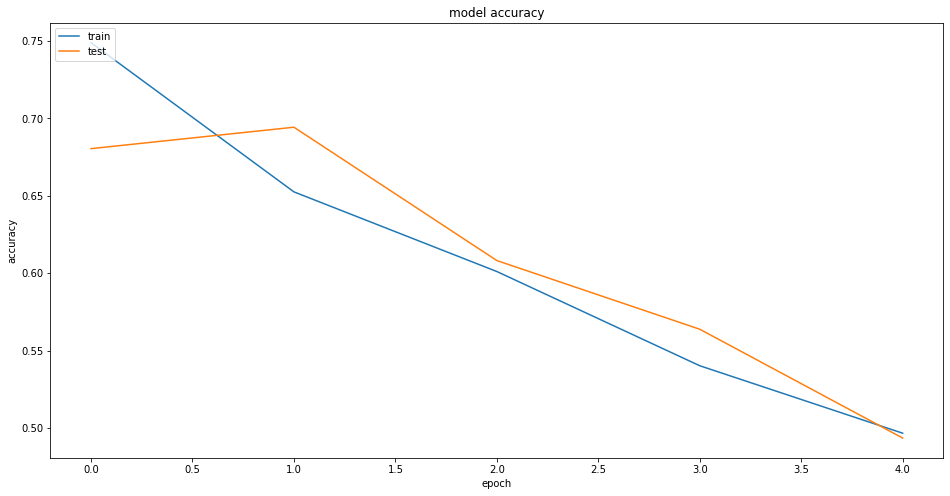

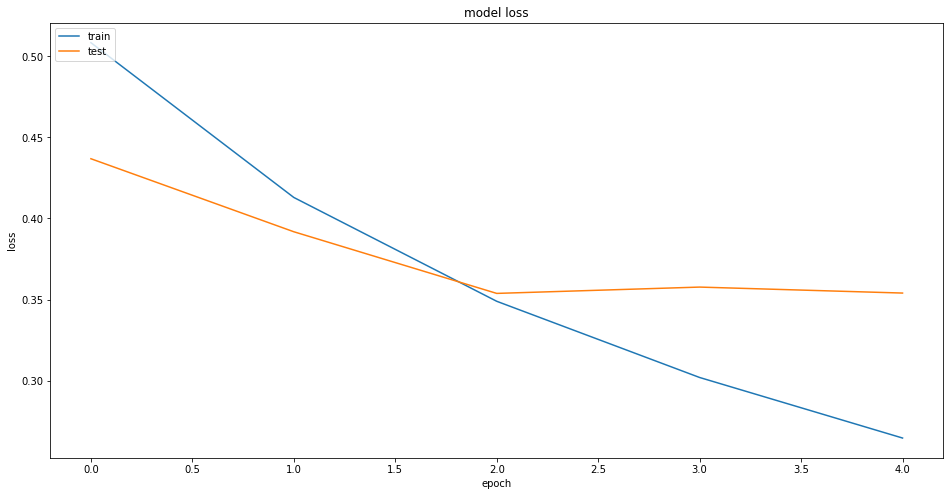

In [10]:
plot_training_history(history)

### Predict and evaluate

In [13]:
# get predictions
y_pred = model.predict(x_val)

# round probabilities to get vector of labels
y_pred = y_pred.round()

# evaluate model
evaluate_model(y_val, y_pred, print_results=True);

Accuracy score: 0.23
Precision score: 0.85 with average parameter: micro
Recall score: 0.81 with average parameter: micro
F1 score: 0.83 with average parameter: micro
Hamming loss: 0.15
